In [1]:
from inlaw.nb_util import setup_nb
setup_nb()

In [2]:
import inlaw.inla as inla
import inlaw.quad as quad
import inlaw.berry as berry
import numpy as np
from numpy import nan
import matplotlib.pyplot as plt
import scipy.stats
import jax
import jax.numpy as jnp
import numpyro.infer
import numpyro.distributions as dist

/Users/tbent/.mambaforge/envs/imprint2/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
N = 100
data = berry.figure2_data(N=N)

In [4]:
sig2_rule = quad.log_gauss_rule(15, 1e-6, 1e3)
ops = berry.optimized(sig2_rule.pts)
p_ex = dict(sig2=np.array([nan]), theta=np.zeros(4))
lj_f = berry.log_joint(4)
ops = inla.from_log_joint(lj_f, p_ex)
p_pinned = dict(sig2=sig2_rule.pts, theta=None)
logpost, x_max, hess_info, iters = jax.vmap(
    ops.laplace_logpost, in_axes=(None, None, 0)
)(jnp.zeros((15, 4)), p_pinned, data)
sig2_post = inla.exp_and_normalize(logpost, sig2_rule.wts[None], axis=1)

In [5]:
invv = jax.jit(jax.vmap(jax.vmap(ops.invert)))
inv_hess = invv(hess_info)
appx_gaussian_cov = -inv_hess[0,:]
std_dev = np.sqrt(np.diagonal(appx_gaussian_cov, axis1=-2, axis2=-1))

## Set up the full laplace appx

In [6]:
def cond_laplace_logpost_scalar(cx, x_max, inv_hess_row, sig2, data, arm_idx):
    return ops.cond_laplace_logpost(
        x_max[None],
        inv_hess_row[None],
        dict(sig2=sig2[None], theta=None),
        data,
        cx[None],
        arm_idx,
        True,
    )[0]


In [7]:
arm_logpost_f = jax.jit(
    jax.vmap(
        jax.vmap(
            jax.vmap(
                cond_laplace_logpost_scalar, in_axes=(0, 0, 0, 0, None, None)
            ), in_axes=(0, 0, 0, None, 0, None)
        ),
        in_axes=(0, None, None, None, None, None),
    ),
    static_argnums=(5,),
)
arm_post = []
arm_cx = []
for arm_idx in range(4):
    cx, wts = inla.gauss_hermite_grid(
        x_max, inv_hess[..., arm_idx, :], arm_idx, n=25
    )
    arm_logpost = arm_logpost_f(
        cx, x_max, inv_hess[:, :, arm_idx], p_pinned['sig2'], data, arm_idx
    )
    arm_cx.append(cx)
    arm_post.append(inla.exp_and_normalize(arm_logpost, wts, axis=0))
arm_cx = jnp.array(arm_cx)
arm_post = jnp.array(arm_post)

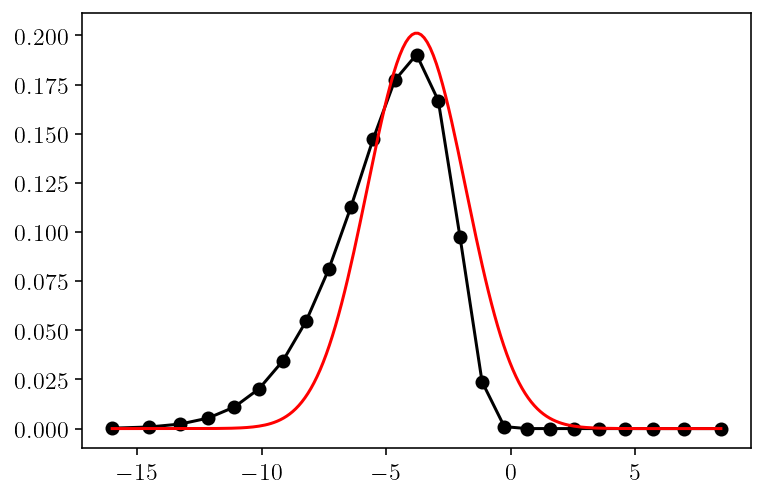

In [496]:
armi_idx = 0
sig_idx = 10
Asd = std_dev[sig_idx, armi_idx]
Amu = x_max[0, sig_idx, armi_idx]
arm_xs = arm_cx[armi_idx,:,0,sig_idx]
xs = np.linspace(np.min(arm_xs), np.max(arm_xs), 200)
plt.plot(arm_xs, arm_post[armi_idx,:,0,sig_idx], 'k-o')
plt.plot(xs, scipy.stats.norm.pdf(xs, loc=Amu, scale=Asd), 'r-')
plt.show()

## Compute a Taylor expansion.

Currently, done with automatic differentiation, but it should be done analytically in the future.

In [559]:
def derivative(order):
    f = cond_laplace_logpost_scalar
    for i in range(order):
        f = jax.grad(f)
    return jax.jit(
        jax.vmap(
            jax.vmap(
                jax.vmap(
                    f, in_axes=(0, 0, 0, 0, None, None)
                ), in_axes=(0, 0, 0, None, 0, None)
            ),
            in_axes=(0, None, None, None, None, None),
        ),
        static_argnums=(5,),
    )

d_fs = [derivative(d) for d in [0, 1,2,3,4]]

((5, 100, 15),
 array([-3.13562366e+01, -1.99520573e-03, -6.96614613e-02, -5.57822794e-02, -5.51537242e-02]))

In [576]:
arm_idx = 0
cx, wts = inla.gauss_hermite_grid(
    x_max, inv_hess[..., arm_idx, :], arm_idx, n=25
)
ds = []
for i in range(5):
    ds.append(d_fs[i](
        x_max[None, ..., arm_idx], x_max, inv_hess[:, :, arm_idx], p_pinned['sig2'], data, arm_idx
    )[0])
ds = np.array(ds)
ds.shape, ds[:, 0, -4]

CPU times: user 19 ms, sys: 4.27 ms, total: 23.3 ms
Wall time: 21.8 ms


((5, 100, 15),
 array([-3.13562366e+01, -1.99520573e-03, -6.96614613e-02, -5.57822794e-02, -5.51537242e-02]))

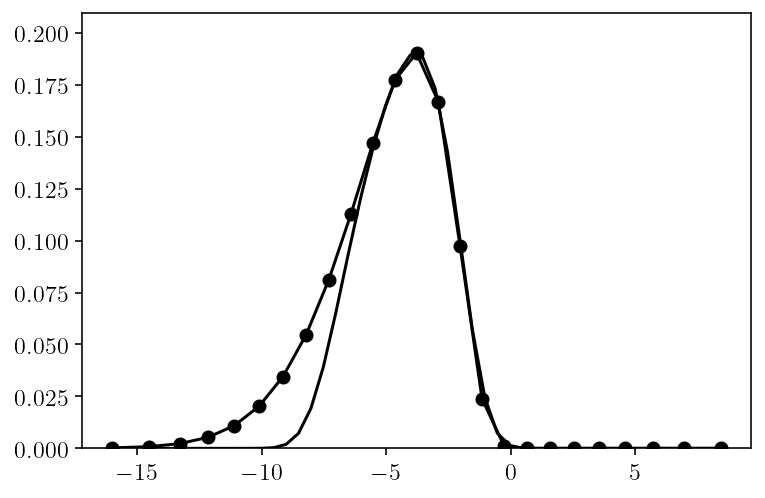

In [560]:
def taylor(x, mu, sd, derivs):
    xh = (x - mu)
    logp = (
        np.log(arm_post[0, 12, 0, sig_idx])
        + xh * derivs[1]
        + (1 / 2) * xh ** 2 * derivs[2]
        + (1 / 6) * xh ** 3 * derivs[3]
        + (1 / 24) * xh ** 4 * derivs[4]
    )
    return np.exp(logp)


expansion_xs = cx[:, 0, sig_idx]
expansion_mu = x_max[0, sig_idx, arm_idx]
expansion_sd = std_dev[sig_idx, arm_idx]

Asd = std_dev[sig_idx, arm_idx]
Amu = x_max[0, sig_idx, arm_idx]
arm_xs = arm_cx[arm_idx, :, 0, sig_idx]
arm_p = arm_post[arm_idx, :, 0, sig_idx]
xs = np.linspace(np.min(arm_xs), np.max(arm_xs), 50)
expansion_pdf = taylor(xs, expansion_mu, expansion_sd, ds[:, 0, sig_idx])
plt.plot(arm_xs, arm_p, 'k-o')
plt.plot(xs, expansion_pdf, 'k-')
plt.ylim([np.min(arm_p), np.max(arm_p) * 1.1])
plt.show()

## Set up the tools for Skew-Normal distributions.

In [ ]:
gamma0, gamma1, gamma2, gamma3, gamma4 = ds[:, 0, sig_idx]

In [611]:
def log_normal_pdf(xt):
    return jax.scipy.stats.norm.logpdf(xt)


def log_normal_cdf(xt):
    return jax.scipy.stats.norm.logcdf(xt)


def sn_log_pdf(z, xi, w, a):
    xt = (z - xi) / w
    return jnp.log(2) - jnp.log(w) + log_normal_pdf(xt) + log_normal_cdf(a * xt)


def sn_pdf(xs, xi, w, a):
    return scipy.stats.skewnorm(a, loc=xi, scale=w).pdf(xs)


def sn_mode_f(xi, w, a):
    delta = a / jnp.sqrt(1 + a**2)
    mu_z = jnp.sqrt(2 / jnp.pi) * delta
    sigma_z = jnp.sqrt(1 - mu_z**2)
    sn_skew = (
        (4 - jnp.pi)
        * 0.5
        * (delta * jnp.sqrt(2 / jnp.pi)) ** 3
        / (1 - 2 * delta**2 / jnp.pi) ** 1.5
    )
    m0 = (
        mu_z
        - sn_skew * sigma_z / 2
        - jnp.sign(a) / 2 * jnp.exp(-2 * jnp.pi / jnp.abs(a))
    )
    return xi + w * m0


def sn_rue_mode_f(xi, w, a):
    return (
        (a / w) * (np.sqrt(2 * np.pi) + 2 * xi * (a / w)) / (np.pi + 2 * (a / w) ** 2)
    )


def sn_mean_f(xi, w, a):
    delta = a / jnp.sqrt(1 + a**2)
    return xi + w * delta * np.sqrt(2 / np.pi)


def sn_var_f(xi, w, a):
    delta = a / jnp.sqrt(1 + a**2)
    return w**2 * (1 - 2 * delta**2 / jnp.pi)


def make_sn_deriv(order):
    f = sn_log_pdf
    for i in range(order):
        f = jax.grad(f)
    return jax.jit(f)


sn_ds = [make_sn_deriv(i) for i in range(5)]


def report(soln):
    mode = sn_mode_f(*soln)
    mean = sn_mean_f(*soln)
    var = sn_var_f(*soln)
    mean2, var2, skew, kurt = scipy.stats.skewnorm(
        soln[2], loc=soln[0], scale=soln[1]
    ).stats(moments="mvsk")
    np.testing.assert_allclose(mean2, mean)
    np.testing.assert_allclose(var2, var)

    out = dict(
        xi=soln[0],
        omega=soln[1],
        a=soln[2],
        rue_mode=sn_rue_mode_f(*soln),
        mode=mode,
        mean=mean,
        var=var,
        skew=skew,
        kurt=kurt,
    )

    for i in range(1, len(sn_ds)):
        out[f"d{i}"] = sn_ds[i](out['mode'], *soln)

    for i in range(1, len(sn_ds)):
        out[f"d{i}_rue"] = sn_ds[i](out['rue_mode'], *soln)
    return out


In [612]:

def rue_skew_normal_fit(gamma1, gamma2, gamma3):
    C = (4 - np.pi) * np.sqrt(2) / (np.pi ** 1.5)
    R = np.cbrt(gamma3 / C)
    w_a = R ** 2 * (1 - 2 / np.pi)
    w_b = 1 + (1.0 / gamma2) * R ** 2
    w_c = (1.0 / gamma2)
    if w_a == 0:
        w2 = -w_c / w_b
    else:
        w2_1 = (-w_b + np.sqrt(w_b ** 2 - 4 * w_a * w_c)) / (2 * w_a)
        w2_2 = (-w_b - np.sqrt(w_b ** 2 - 4 * w_a * w_c)) / (2 * w_a)
    w2 = w2_1
    w = np.sqrt(w2) * (-np.sign(gamma3))
    a = R * w
    delta = a / np.sqrt(1 + a ** 2)
    xi = gamma1 - w * delta * np.sqrt(2 / np.pi)
    return xi, w, a

rue_soln = rue_skew_normal_fit(gamma1, gamma2, gamma3)

In [613]:
report(rue_soln)

{'xi': 2.261210141856084,
 'omega': 3.014819585665194,
 'a': -2.8628764221802645,
 'rue_mode': 0.34332349049125144,
 'mode': DeviceArray(0.79737909, dtype=float64),
 'mean': DeviceArray(-0.00971626, dtype=float64),
 'var': DeviceArray(3.9320304, dtype=float64),
 'skew': array(-0.64468462),
 'kurt': array(0.48713488),
 'd1': DeviceArray(0.00396376, dtype=float64),
 'd2': DeviceArray(-0.34205575, dtype=float64),
 'd3': DeviceArray(-0.23753121, dtype=float64),
 'd4': DeviceArray(-0.07737743, dtype=float64),
 'd1_rue': DeviceArray(0.13630296, dtype=float64),
 'd2_rue': DeviceArray(-0.24480141, dtype=float64),
 'd3_rue': DeviceArray(-0.18586621, dtype=float64),
 'd4_rue': DeviceArray(-0.14247261, dtype=float64)}

In [616]:
gamma1, gamma3

(-0.009716262625455222, -0.25432153325092355, -0.18668414543379036)

In [609]:
def obj_rue(args):
    r = report(args)
    return r['mean'] -  ** 2 + (r['var'] - (-1.0 / gamma2)) ** 2 + (r['d3'] - gamma3) ** 2

def obj_f4(args):
    r = report(args)
    return r['mode'] ** 2 + (r['d1'] - gamma1) ** 2 + (r['d2'] - gamma2) ** 2
    # return mode ** 2 + (deriv2 - gamma2) ** 2 + (deriv3 - gamma3) ** 2# + (deriv4 - gamma4) ** 2
    # return mode ** 2 + (deriv2 - gamma2) ** 2 + (deriv4 - gamma4) ** 2
    # return mode ** 2 + (deriv1 - gamma1) ** 2 + (deriv2 - gamma2) ** 2 + (deriv3 - gamma3) ** 2# + (deriv4 - gamma4) ** 2
    # return mode ** 2 + (var - (-1.0 / gamma2)) ** 2 + (deriv3 - gamma3) ** 2 + (deriv4 - gamma4) ** 2
    
def grad_desc(lr, x0, f, n_iter=1000):
    soln = x0#np.array([sn_xi, sn_w, sn_a])
    f_jit = jax.jit(f)
    grad_f_jit = jax.jit(jax.grad(f))
    for i in range(n_iter):
        obj = f_jit(soln)
        grad = grad_f_jit(soln)
        if i % 100 == 0 or i == n_iter - 1:
            print(soln, obj, grad)
        soln -= grad * lr
    return soln
# soln = grad_desc(0.1, np.array([sn_xi, sn_w, sn_a]), obj_f)
soln4 = grad_desc(0.1, np.array(rue_soln), obj_f4)

[ 2.26121014  3.01481959 -2.86287642] 0.6436978467148138 [ 1.59475818 -0.81417972 -0.30010078]
[ 1.66027381  3.36493549 -2.72642484] 0.00029005126527646116 [-0.00162209 -0.00270231 -0.00124763]
[ 1.67321756  3.38643967 -2.71633875] 0.00021571262647540024 [-0.00101399 -0.0016789  -0.00080278]
[ 1.68139713  3.39993996 -2.70976522] 0.00018605409303604374 [-0.00064778 -0.00106481 -0.00053058]
[ 1.686657    3.40855029 -2.70537289] 0.00017378131915128076 [-0.00041931 -0.00068266 -0.00035901]
[ 1.69007555  3.41408324 -2.70236792] 0.00016858221875500746 [-0.00027363 -0.0004394  -0.00024887]
[ 1.69231187  3.4176432  -2.70025868] 0.00016634230693518082 [-0.00017943 -0.00028229 -0.00017734]
[ 1.69378042  3.41992312 -2.69873333] 0.00016536245234228386 [-0.00011799 -0.00017989 -0.00013054]
[ 1.69474666  3.42136615 -2.69759093] 0.00016492530691194178 [-7.76666203e-05 -1.12729773e-04 -9.97686374e-05]
[ 1.69538269  3.42225928 -2.6967007 ] 0.00016472364764151716 [-5.11100274e-05 -6.85146661e-05 -7.9474

In [610]:
def obj_f5(args):
    xi, w, a = args
    mode = sn_mode_f(xi, w, a)
    var = sn_var_f(xi, w, a)
    deriv1 = sn_ds[1](mode, xi, w, a)
    deriv2 = sn_ds[2](mode, xi, w, a)
    deriv3 = sn_ds[3](mode, xi, w, a)
    deriv4 = sn_ds[4](mode, xi, w, a)
    return mode ** 2 + (deriv2 - gamma2) ** 2 + (deriv3 - gamma3) ** 2
soln5 = grad_desc(0.1, np.array(rue_soln), obj_f5)

[ 2.26121014  3.01481959 -2.86287642] 0.646096127746218 [ 1.59475818 -0.83818054 -0.32272853]
[ 1.63160997  3.32925884 -2.78797044] 0.0009478855926926806 [ 0.00058998 -0.00059144  0.00415387]
[ 1.62981523  3.34053726 -2.82312941] 0.0008093120615760941 [-0.00010217 -0.00148085  0.00303876]
[ 1.6320042   3.3565591  -2.85088284] 0.0007059435818768662 [-0.00029412 -0.00166467  0.00256445]
[ 1.63519332  3.37314399 -2.8751359 ] 0.0006185746155724775 [-0.00033124 -0.00163485  0.0023029 ]
[ 1.63848573  3.38908168 -2.89720533] 0.000543376024770811 [-0.00032363 -0.00154784  0.00211667]
[ 1.64163087  3.40407807 -2.91759139] 0.0004783338162057323 [-0.00030443 -0.00145032  0.00196279]
[ 1.64457071  3.41810805 -2.93653574] 0.00042189331643880746 [-0.00028335 -0.00135562  0.0018272 ]
[ 1.64730298  3.43122067 -2.95419172] 0.00037277685929843 [-0.00026313 -0.00126713  0.0017047 ]
[ 1.64984044  3.44348154 -2.97067702] 0.00032992176628017847 [-0.00024444 -0.00118532  0.00159288]
[ 1.6521761   3.45484502 

In [543]:
def obj_f6(args):
    xi, w, a = args
    mode = sn_mode_f(xi, w, a)
    var = sn_var_f(xi, w, a)
    deriv0 = sn_log_pdf(mode, xi, w, a)
    deriv1 = sn_d1(mode, xi, w, a)
    deriv2 = sn_d2(mode, xi, w, a)
    deriv3 = sn_d3(mode, xi, w, a)
    deriv4 = sn_d4(mode, xi, w, a)
    return mode ** 2 + (deriv0 - gamma0) ** 2 + (deriv1 - gamma1) ** 2 + (deriv2 - gamma2) ** 2# + (deriv3 - gamma3) ** 2
soln6 = grad_desc(0.1, np.array([sn_xi, sn_w, sn_a]), obj_f6, n_iter=10000)

[ 2.26121014  3.01481959 -2.86287642] 688.5749350848894 [  1.59475818 -18.21385658  -4.55075628]
[  5.21428445  29.90319988 -14.21810293] 581.6746578775761 [-0.29436931 -1.55984341 -0.02194641]
[  7.64550318  42.66913153 -13.99705935] 564.6203887756351 [-0.20781114 -1.07583811 -0.02196426]
[  9.53290317  52.2957793  -13.78094433] 554.966329633432 [-0.17319842 -0.8689633  -0.0212136 ]
[ 11.16062231  60.33891221 -13.57304365] 548.2203446143784 [-0.15369847 -0.74737247 -0.02035235]
[ 12.63043069  67.38174681 -13.37382138] 543.0374165961803 [-0.14092186 -0.66504095 -0.01948614]
[ 13.9921235   73.71885663 -13.18314682] 538.831331764872 [-0.1317837  -0.60457168 -0.018646  ]
[ 15.27421234  79.52362958 -13.00069276] 535.293627347942 [-0.12485709 -0.55774177 -0.01784358]
[ 16.49469713  84.90833614 -12.82605614] 532.2419549162524 [-0.1193838  -0.52009387 -0.01708335]
[ 17.66573664  89.95060737 -12.65880687] 529.559562207332 [-0.11492116 -0.48897483 -0.01636657]
[ 18.79596655  94.70677068 -12.498

In [522]:
# report(soln),
report(soln4)

(DeviceArray(-1.67875321e-05, dtype=float64),
 DeviceArray(-0.86472146, dtype=float64),
 DeviceArray(5.15921567, dtype=float64),
 -0.13790341867172687)

In [523]:
soln2_mod = soln4.to_py().copy()
soln2_mod[0] -= 0.3
soln2_mod[1] *= 1.2
soln2_mod[2] *= 1.7

we know:
- the mode
- the first derivative at the mode
- the second derivative at the mode
- the third derivative at the mode

these are the things we should fit. not the crap in rue 2009.

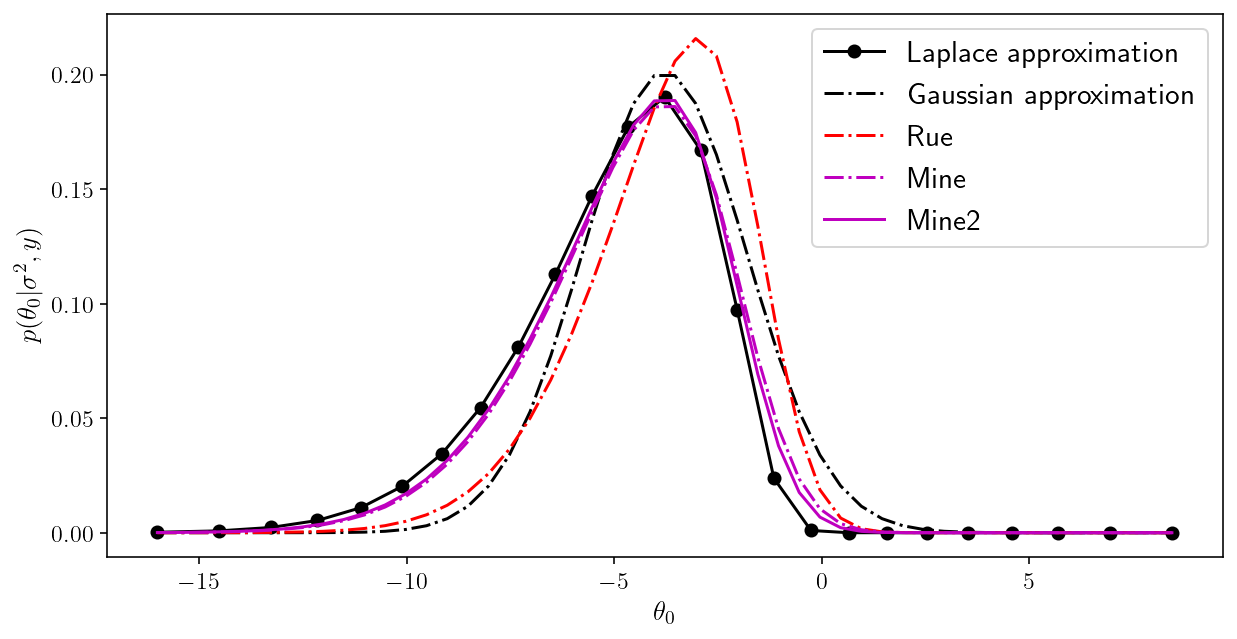

In [524]:

plt.figure(figsize=(10, 5))
plt.plot(
    arm_xs, arm_post[armi_idx, :, 0, sig_idx], "k-o", label="Laplace approximation"
)
plt.plot(
    xs,
    scipy.stats.norm.pdf(xs, loc=Amu, scale=Asd),
    "k-.",
    label="Gaussian approximation",
)
# plt.plot(xs, expansion_pdf, "r-", label="Taylor expansion")
plt.plot(xs, skewnorm_pdf(xs - expansion_mu, sn_xi, sn_w, sn_a), 'r-.', label='Rue')
# plt.plot(xs, skewnorm_pdf(xs - expansion_mu, *soln), 'm-.', label='SkewN2')
# plt.plot(xs, skewnorm_pdf(xs - expansion_mu, *soln), 'b-.', label='Rue')
plt.plot(xs, skewnorm_pdf(xs - expansion_mu, *soln4), 'm-.', label='Mine')
plt.plot(xs, skewnorm_pdf(xs - expansion_mu, *soln5), 'm-', label='Mine2')
# plt.plot(xs, skewnorm_pdf(xs - expansion_mu, *soln2_mod), 'g-.', label='Mine2')
# plt.axvline(mode1 + expansion_mu, color='b', label='Mode 1')
# plt.axvline(mode2 + expansion_mu, color='b', label='Mode 2')
# plt.ylim([0, 0.25])
plt.xlabel(r'$\theta_0$')
plt.ylabel(r'$p(\theta_0 | \sigma^2, y)$')
plt.legend()
plt.show()


## Junk

In [ ]:
for i in range(5):
    f = sn_log_pdf
    for j in range(i):
        f = jax.grad(f)
    print(jax.jit(f)(sn_mode_f(*soln4), *soln4))

-1.674194984423564
0.003113871679694612
-0.2544312371799874
-0.13790341867172687
-0.031535299480848954


In [ ]:
# def obj_f2(args):
#     xi, w, a = args
#     mode = sn_mode_f(xi, w, a)
#     var = sn_var_f(xi, w, a)
#     deriv3 = sn_d3(mode, xi, w, a)
#     check_idx = 6
#     x_check = arm_cx[0, check_idx, 0, sig_idx] - expansion_mu
#     f_check = jnp.exp(sn_log_pdf(x_check, xi, w, a))
#     f_check_true = arm_post[0, check_idx, 0, sig_idx]
#     C = 1000.0
#     return mode ** 2 + (var - (-1.0 / gamma2)) ** 2 + (deriv3 - gamma3) ** 2 + C * (f_check - f_check_true) ** 2
# soln2 = grad_desc(0.03, np.array([sn_xi, sn_w, sn_a]), obj_f2)
# report(soln2)

[ 2.26121014  3.01481959 -2.86287642] 1.2006471989367729 [ 2.02448465 -1.71539904 -0.30813654]
[ 1.3324487   3.06699784 -2.96476467] 0.14321416360246378 [ 0.08314131 -0.00349293  0.09543459]
[ 1.2908462   3.07970844 -3.09350462] 0.13026340622467547 [ 0.006851   -0.00927629  0.07549581]
[ 1.28390129  3.09190212 -3.19331351] 0.1234683444522504 [ 0.00356967 -0.00693546  0.05791497]
[ 1.27916478  3.10085905 -3.26965307] 0.11950131731349728 [ 0.002782   -0.00507257  0.04418037]
[ 1.27545689  3.10743085 -3.32778565] 0.11720236813842468 [ 0.00216927 -0.00373597  0.03358085]
[ 1.27258301  3.11228459 -3.37190955] 0.1158784380654618 [ 0.00167106 -0.00276719  0.02545089]
[ 1.27037822  3.11588663 -3.40531399] 0.11511984877031872 [ 0.00127683 -0.0020576   0.01924538]
[ 1.26869807  3.11856857 -3.43055183] 0.11468691701757709 [ 0.00097042 -0.00153407  0.01452716]
[ 1.26742342  3.12056997 -3.44958963] 0.1144406033937393 [ 0.00073489 -0.00114589  0.0109507 ]
[ 1.26645933  3.12206591 -3.46393315] 0.1143